# Attention Scoring Functions


In :numref:`sec_attention-pooling`,
we used a number of different distance-based kernels, including a Gaussian kernel to model
interactions between queries and keys. As it turns out, distance functions are slightly more expensive to compute than dot products. As such, 
with the softmax operation to ensure nonnegative attention weights,
much of the work has gone into *attention scoring functions* $a$ in :eqref:`eq_softmax_attention` and :numref:`fig_attention_output` that are simpler to compute. 

![Computing the output of attention pooling as a weighted average of values, where weights are computed with the attention scoring function $\mathit{a}$ and the softmax operation.](../img/attention-output.svg)
:label:`fig_attention_output`

In [1]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN

  Activating project at `/workspace/workspace/d2l-julia/d2lai`


## Dot Product Attention


Let's review the attention function (without exponentiation) from the Gaussian kernel for a moment:

$$
a(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2.
$$

First, note that the final term depends on $\mathbf{q}$ only. As such it is identical for all $(\mathbf{q}, \mathbf{k}_i)$ pairs. Normalizing the attention weights to $1$, as is done in :eqref:`eq_softmax_attention`, ensures that this term disappears entirely. Second, note that both batch and layer normalization (to be discussed later) lead to activations that have well-bounded, and often constant, norms $\|\mathbf{k}_i\|$. This is the case, for instance, whenever the keys $\mathbf{k}_i$ were generated by a layer norm. As such, we can drop it from the definition of $a$ without any major change in the outcome. 

Last, we need to keep the order of magnitude of the arguments in the exponential function under control. Assume that all the elements of the query $\mathbf{q} \in \mathbb{R}^d$ and the key $\mathbf{k}_i \in \mathbb{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. To ensure that the variance of the dot product still remains $1$ regardless of vector length, we use the *scaled dot product attention* scoring function. That is, we rescale the dot product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used, e.g., in Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017`:

$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$
:eqlabel:`eq_dot_product_attention`

Note that attention weights $\alpha$ still need normalizing. We can simplify this further via :eqref:`eq_softmax_attention` by using the softmax operation:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$
:eqlabel:`eq_attn-scoring-alpha`

As it turns out, all popular attention mechanisms use the softmax, hence we will limit ourselves to that in the remainder of this chapter.

## Convenience Functions

We need a few functions to make the attention mechanism efficient to deploy. This includes tools for dealing with strings of variable lengths (common for natural language processing) and tools for efficient evaluation on minibatches (batch matrix multiplication). 


### Masked Softmax Operation

One of the most popular applications of the attention mechanism is to sequence models. Hence we need to be able to deal with sequences of different lengths. In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences (see :numref:`sec_machine_translation` for an example). These special tokens do not carry meaning. For instance, assume that we have the following three sentences:

```
Dive  into  Deep    Learning 
Learn to    code    <blank>
Hello world <blank> <blank>
```


Since we do not want blanks in our attention model we simply need to limit $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ to $\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ for however long, $l \leq n$, the actual sentence is. Since it is such a common problem, it has a name: the *masked softmax operation*. 

Let's implement it. Actually, the implementation cheats ever so slightly by setting the values of $\mathbf{v}_i$, for $i > l$, to zero. Moreover, it sets the attention weights to a large negative number, such as $-10^{6}$, in order to make their contribution to gradients and values vanish in practice. This is done since linear algebra kernels and operators are heavily optimized for GPUs and it is faster to be slightly wasteful in computation rather than to have code with conditional (if then else) statements.


In [2]:
function _sequence_mask_(X::AbstractArray, valid_len, value::T = 0) where {T}
    n, q, b = size(X)
    device = isa(X, CuArray) ? cu : identity
    key_ids = reshape(device(collect(1:n)), n, 1, 1)

    if eltype(valid_len) <: AbstractVector
        # valid_len is Vector of Vectors
        # Build a (n, q, b) mask with broadcasting
        valid_mat = zeros(Int, q, b)
        for j in 1:b
            valid_mat[:, j] .= valid_len[j]
        end
        valid_mat = reshape(device(valid_mat), 1, q, b)
    else
        # valid_len is simple vector
        valid_mat = reshape(device(collect(valid_len)), 1, 1, b)
    end
    

    mask = key_ids .<= valid_mat  # shape: (n, q, b)
    mask_f = T.(mask)
    return X .* mask_f .+ value .* (1 .- mask_f)
end

function masked_softmax(X, valid_lens, value = 0.)
    if isnothing(valid_lens)
        return softmax(X, dims = 1)
    else
        X_ = _sequence_mask_(X, valid_lens, -1e6)
        return softmax(X_, dims = 1)
    end
end

masked_softmax (generic function with 2 methods)

In [3]:
X = rand(4, 2, 2)
valid_lens = [2, 3]

masked_softmax(X, valid_lens)

4×2×2 Array{Float64, 3}:
[:, :, 1] =
 0.342791  0.525284
 0.657209  0.474716
 0.0       0.0
 0.0       0.0

[:, :, 2] =
 0.391309  0.331539
 0.361107  0.283358
 0.247584  0.385103
 0.0       0.0

If we need more fine-grained control to specify the valid length for each of the two vectors of every example, we simply use a two-dimensional tensor of valid lengths. This yields:



In [4]:
masked_softmax(X, [[1, 3], [2, 4]])


4×2×2 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.384194
 0.0  0.347209
 0.0  0.268596
 0.0  0.0

[:, :, 2] =
 0.52007  0.273421
 0.47993  0.233685
 0.0      0.317595
 0.0      0.175299

### Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that 

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.
$$

Then the batch matrix multiplication (BMM) computes the elementwise product

$$\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$
:eqlabel:`eq_batch-matrix-mul`

Let's see this in action in a deep learning framework.


In [5]:
Q = randn(3, 4, 2)
K = randn(4, 6, 2)
M = batched_mul(Q, K)
@assert size(M) == (3, 6, 2)

## Scaled Dot Product Attention

Let's return to the dot product attention introduced in :eqref:`eq_dot_product_attention`. 
In general, it requires that both the query and the key
have the same vector length, say $d$, even though this can be addressed easily by replacing 
$\mathbf{q}^\top \mathbf{k}$ with $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ where $\mathbf{M}$ is a matrix suitably chosen for translating between both spaces. For now assume that the dimensions match. 

In practice, we often think of minibatches for efficiency,
such as computing attention for $n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$. The scaled dot product attention 
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
thus can be written as 

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

Note that when applying this to a minibatch, we need the batch matrix multiplication introduced in :eqref:`eq_batch-matrix-mul`. In the following implementation of the scaled dot product attention,
we use dropout for model regularization.

In [6]:
struct DotProductAttention{D, A}
    dropout::D 
    args::A 
end

function (m::DotProductAttention)(queries, keys, values, valid_len = nothing)
    # keys -> d x num_keys x batch_size
    # queries -> d x num_queries x batch_size
    d = size(queries, 1)
    scores = batched_mul(batched_transpose(keys), queries) ./ sqrt(d)
    # scores -> num_keys x num_queries x batch_size 
    attention_weights = masked_softmax(scores, valid_len)
    # attention_weights -> num_keys x num_queries x batch_size
    return batched_mul(values, m.dropout(attention_weights)), attention_weights
end


To illustrate how the `DotProductAttention` works,
we use the same keys, values, and valid lengths from the earlier toy example for additive attention. For the purpose of our example we assume that we have a minibatch size of $2$, a total of $10$ keys and values, and that the dimensionality of the values is $4$. Lastly, we assume that the valid length per observation is $2$ and $6$ respectively. Given that, we expect the output to be a $2 \times 1 \times 4$ tensor, i.e., one row per example of the minibatch.



In [7]:
batch_size = 2 
num_key_val = 10
num_queries = 1
d = d_k = d_q = 2
d_v = 4
queries = randn(d, num_queries, batch_size)
keys = randn(d, num_key_val, batch_size)
vals = randn(d_v, num_key_val, batch_size)

valid_len = [2, 6]
dot_product_attn = DotProductAttention(Flux.Dropout(0.5), nothing)
scores, attn_weights = dot_product_attn(queries, keys, vals, valid_len)
@assert size(scores) == (4, 1, 2)

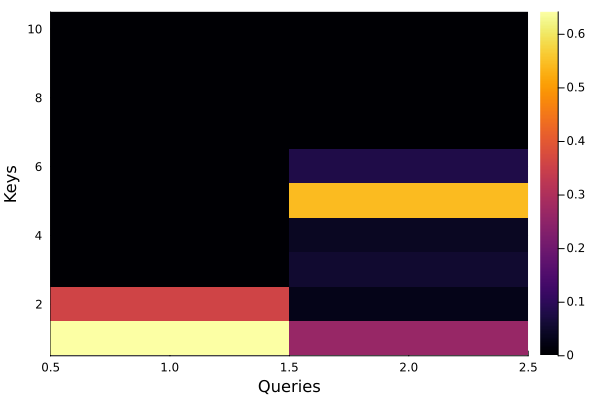

In [34]:
d2lai.show_heatmaps(reshape(attn_weights, 10, 2, 1, 1), "Queries", "Keys")

## Additive Attention

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimension,
we can either use a matrix to address the mismatch via $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, or we can use additive attention 
as the scoring function. Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings. 
Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the *additive attention* scoring function :cite:`Bahdanau.Cho.Bengio.2014` is given by 

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, 
and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization. 
An equivalent interpretation of :eqref:`eq_additive-attn` is that the query and key are concatenated
and fed into an MLP with a single hidden layer. 
Using $\tanh$ as the activation function and disabling bias terms, 
we implement additive attention as follows:

In [35]:

struct AdditiveAttention{W, A, D} <: AbstractModel
    weights::W 
    dropout::D 
    args::A 
end

Flux.@layer AdditiveAttention trainable = (weights,)

function AdditiveAttention(k_d, q_d, v_d, num_hiddens::Int64, dropout::Float64; kw...)
    W_k = Dense(k_d => num_hiddens; bias = false)
    W_q = Dense(q_d => num_hiddens; bias = false)
    W_v = Dense(num_hiddens => 1; bias = false)
    
    AdditiveAttention((; W_k, W_q, W_v), Flux.Dropout(dropout), (;))
end

function (m::AdditiveAttention)(queries, keys, values, valid_lens)
    queries = m.weights.W_q(queries) # num_hiddens x num_queries x batch_size
    keys = m.weights.W_k(keys) # num_hiddens x num_keys x batch_size
    features = Flux.unsqueeze(queries, 2) .+ Flux.unsqueeze(keys, 3) # num_hiddens x num_keys x num_queries x batch_size 
    features = tanh.(features)
    scores = m.weights.W_v(features) # 1 x num_keys x num_queries x batch_size 
    scores = dropdims(scores, dims = 1) # num_keys x num_queries x batch_size
    attention_weights = masked_softmax(scores, valid_lens) # num_keys x num_queries x batch_size
    return batched_mul(values, m.dropout(attention_weights)), attention_weights 
    # num_hidden x num_queries x batch_size , num_keys x num_queries x batch_size
end

Let's see how `AdditiveAttention` works. In our toy example we pick queries, keys and values of size 
$(2, 1, 20)$, $(2, 10, 2)$ and $(2, 10, 4)$, respectively. This is identical to our choice for `DotProductAttention`, except that now the queries are $20$-dimensional. Likewise, we pick $(2, 6)$ as the valid lengths for the sequences in the minibatch.


In [36]:
d_q = 20 
queries = randn(d_q, num_queries, batch_size)

m = AdditiveAttention(d_k, d_q, d_v, 8, 0.)

scores, attention_wts = m(queries, keys, vals, valid_len)
@assert size(scores) == (d_v, num_queries, batch_size)

When reviewing the attention function we see a behavior that is qualitatively quite similar to that of `DotProductAttention`. That is, only terms within the chosen valid length $(2, 6)$ are nonzero.


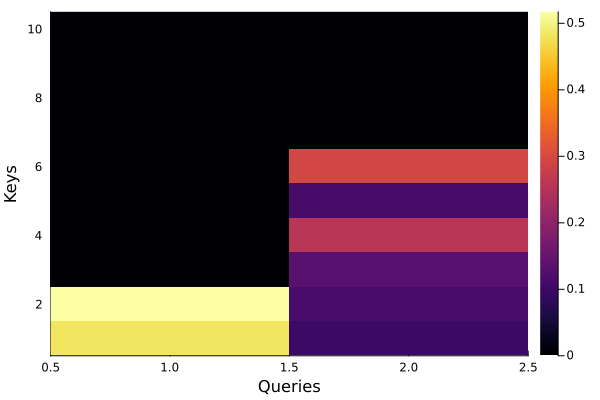

In [37]:
d2lai.show_heatmaps(reshape(attention_wts, 10, 2, 1, 1), "Queries", "Keys")

## Summary

In this section we introduced the two key attention scoring functions: dot product and additive attention. They are effective tools for aggregating across sequences of variable length. In particular, the dot product attention is the mainstay of modern Transformer architectures. When queries and keys are vectors of different lengths,
we can use the additive attention scoring function instead. Optimizing these layers is one of the key areas of advance in recent years. For instance, [NVIDIA's Transformer Library](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/index.html) and Megatron :cite:`shoeybi2019megatron` crucially rely on efficient variants of the attention mechanism. We will dive into this in quite a bit more detail as we review Transformers in later sections. 

## Exercises

1. Implement distance-based attention by modifying the `DotProductAttention` code. Note that you only need the squared norms of the keys $\|\mathbf{k}_i\|^2$ for an efficient implementation. 
1. Modify the dot product attention to allow for queries and keys of different dimensionalities by employing a matrix to adjust dimensions. 
1. How does the computational cost scale with the dimensionality of the keys, queries, values, and their number? What about the memory bandwidth requirements?
